<a href="https://colab.research.google.com/github/AgrawalHimanshi/ML-NLP/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

In [0]:

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [19]:
news_df=build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,LG the most trusted washing machine brand for ...,LG has emerged as the most trusted washing mac...,technology
1,Hacker converts iPhone charging cable into hac...,A hacker who goes by the online handle 'MG' ri...,technology
2,Google discloses it acquired app that solves e...,Google has disclosed it acquired US-based star...,technology
3,Twitter leads $100 million funding in Bengalur...,Bengaluru-based vernacular social networking a...,technology
4,WhatsApp building feature to ban underage user...,WhatsApp has started working on a feature to b...,technology
5,Huawei working on potential alternative to Goo...,Chinese smartphone maker Huawei is reportedly ...,technology
6,Trump says he had dinner with Apple CEO Tim Co...,US President Donald Trump said he was having d...,technology
7,Employees urge Google not to work with US immi...,Google employees have urged Google not to work...,technology
8,Facebook to now alert users of movie releases,Facebook will alert users of new movie release...,technology
9,E-scooter that drives itself to charging stati...,China's Segway-Ninebot Group has unveiled an e...,technology


In [20]:
news_df.news_category.value_counts()

sports        25
world         25
technology    24
Name: news_category, dtype: int64

**Text Wrangling and Pre-processing**

In [0]:
import spacy
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup

import unicodedata

In [22]:
 from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving contractions_py.py to contractions_py.py
User uploaded file "contractions_py.py" with length 3250 bytes


In [0]:
from contractions_py import CONTRACTION_MAP

In [24]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255076 sha256=db471a4add627b0c235700281b9ef66b34413020c1801ddda9ea24d42013412e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3v_zm_pu/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [25]:
!python -m spacy download en_core_web_md

MessageError: ignored

In [0]:
nlp = spacy.load('en', parse = True, tag=True, entity=True)

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

**remove html tags**

In [29]:
def strip_html_tags(text):
  soup=BeautifulSoup(text,"html.parser")
  stripped_text=soup.get_text()
  return stripped_text

strip_html_tags('<html><h2>someone</h2></html>')


'someone'

**Remove accented character**

In [30]:
def remove_accented_chars(text):
  text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text
remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

**Expand contractions**

In [0]:
#def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
 # text=

In [32]:
def remove_special_characters(text, remove_digits=False):
  pattern=r'[a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
  text=re.sub(pattern,'',text)
  return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

In [33]:
def lemmatize_text(text):
  text=nlp(text)
  text=' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

**text stemming**

In [34]:
def simple_stemmer(text):
  ps=nltk.porter.PorterStemmer()
  text=' '.join([ps.stem(word) for word in text.split() ])
  return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

**Remove Stopwords **

In [35]:
def remove_stopwords(text, is_lower_case=False):
  tokens=tokenizer.tokenize(text)
  tokens=[token.strip() for token in tokens]
  if is_lower_case:
     filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
     filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
      
  filtered_text=' '.join(filtered_tokens)
  return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [0]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
  normalized_corpus=[]
  for doc in corpus:
    if html_stripping:
      doc=strip_html_tags(doc)
    # remove accented characters
    if accented_char_removal:
      doc=remove_accented_chars(doc)
     # expand contractions    
    #if contraction_expansion:
     # doc = expand_contractions(doc)
    #text lowercase
    if text_lower_case:
      doc=doc.lower()
    # remove extra newlines
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
     # lemmatize text
    if text_lemmatization:
      doc = lemmatize_text(doc)
    #remove special char and/or digits
    if special_char_removal:
       # insert spaces between special characters to isolate them  
      special_char_pattern = re.compile(r'([{.(-)!}])')  
      doc = special_char_pattern.sub(" \\1 ", doc)
      doc = remove_special_characters(doc, remove_digits=remove_digits) 
    #remove extra white space
    doc=re.sub(' +',' ',doc)
    #remove stop words
    if stopword_removal:
      doc=remove_stopwords(doc, is_lower_case=text_lower_case)
      
    normalized_corpus.append(doc)
    
  return normalized_corpus 

In [0]:

news_df['full_text']=news_df["news_headline"].map(str)+'.'+news_df["news_article"]


In [38]:

news_df['clean_text']=normalize_corpus(news_df['full_text'])
norm_corpus=list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'hacker convert iphone charge cable hacking tool hacker go online handle mg rig iphone charge cable small wi fi enable implant convert hacking tool nearby device within wi fi range attach nearby wi fi network attacker wirelessly transmit malicious payload computer use cable',
 'full_text': "Hacker converts iPhone charging cable into hacking tool.A hacker who goes by the online handle 'MG' rigged an iPhone charging cable with a small Wi-Fi-enabled implant to convert it into a hacking tool. From a nearby device and within Wi-Fi range (or attached to a nearby Wi-Fi network), an attacker can wirelessly transmit malicious payloads on the computer using the cable. "}

In [0]:
news_df.to_csv('news.csv', index=False,encoding='utf-8')

In [0]:
news_df=pd.read_csv('news.csv')

In [0]:
corpus=normalize_corpus(news_df['full_text'], text_lower_case=False, 
                     text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)


In [42]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Hacker,NN,NOUN
1,converts,NNS,NOUN
2,iPhone,NNP,PROPN
3,charging,VBG,VERB
4,cable,NN,NOUN
5,into,IN,ADP
6,hacking,JJ,ADJ
7,tool,NN,NOUN


In [43]:




nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [44]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Hacker,NNP
1,converts,VBZ
2,iPhone,NN
3,charging,VBG
4,cable,NN
5,into,IN
6,hacking,VBG
7,tool,NN


**Shallow Parsing or Chhunking**
-analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. 

In [45]:
nltk.download('conll2000')


[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


True

In [46]:
from nltk.corpus import conll2000
data=conll2000.chunked_sents()

train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1])

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [47]:
from nltk.chunk.util import tree2conlltags, conlltags2tree
wtc=tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [48]:
tree = conlltags2tree(wtc) 
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


**conll_tag_ chunks()** to extract POS and chunk tags from sentences with chunked annotation
**combined_taggers()** to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [0]:
def conll_tag_chunks(chunk_sents):
  tagged_sents=[tree2conlltags(tree) for tree in chunk_sents]
  return [[(t,c) for (w,t,c) in sents] for sents in tagged_sents]

def combined_taggers(train_data, taggers, backoff=None):
  for tagger in taggers:
    backoff=tagger(train_data, backoff=backoff)
    
  return backoff

In [0]:
from nltk.tag import UnigramTagger , BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
  def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_taggers(train_sent_tags, tagger_classes)

  #(word, POS tag, Chunk tag) WTC triples
  def parse(self,tagged_sentence):
    if not tagged_sentence:
      return None
    pos_tags=[tags for word,tags in tagged_sentence]
    chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
    chunk_tags=[chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags=[(word,pos_tag,chunk_tag) for ((word, pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
    return conlltags2tree(wpc_tags)

In [51]:
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [52]:
chunk_tree=ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Hacker/NNP)
  (VP converts/VBZ)
  (NP iPhone/NN charging/VBG cable/NN)
  (PP into/IN)
  (VP hacking/VBG)
  (NP tool/NN))


In [53]:

#visualize this in the form of a tree as follows
#install ghostscript in case nltk throws an error.
from IPython.display import display
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files\\gs\\gs9.27\\bin\\"
display(chunk_tree)

TclError: ignored

Tree('S', [Tree('NP', [('Hacker', 'NNP')]), Tree('VP', [('converts', 'VBZ')]), Tree('NP', [('iPhone', 'NN'), ('charging', 'VBG'), ('cable', 'NN')]), Tree('PP', [('into', 'IN')]), Tree('VP', [('hacking', 'VBG')]), Tree('NP', [('tool', 'NN')])])

**constituency parsing**-represent the internal structure of sentences in terms of a hierarchically ordered structure of their constituents.

In [54]:

from nltk.parse.stanford import StanfordParser
scp = StanfordParser(path_to_jar='D:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                   path_to_models_jar='D:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

LookupError: ignored

In [0]:
from spacy import displacy

In [56]:
displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [57]:

from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='D:\\stanford\\stanford-parser-full-2015-04-20\\stanford-parser.jar',
                               path_to_models_jar='D:\\stanford\\stanford-parser-full-2015-04-20\\stanford-parser-3.5.2-models.jar')    
result = list(sdp.raw_parse(sentence))  
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

LookupError: ignored

**Named Entity Recognition**

In [0]:
sentence=str(news_df.iloc[1].full_text)
sentence_nlp=nlp(sentence)

In [59]:

print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(Wi, 'PERSON'), (-, 'PERSON'), (Fi, 'PERSON'), (-, 'PERSON'), (Wi, 'PERSON'), (-, 'PERSON'), (Fi, 'PERSON'), (Wi, 'ORG'), (-, 'ORG'), (Fi, 'ORG')]


In [60]:
displacy.render(sentence_nlp, style='ent', jupyter=True)

In [0]:
named_entities = []

In [0]:
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
          temp_entity_name = ' '.join([temp_entity_name, term]).strip()
          temp_named_entity = (temp_entity_name, tag)
        else:
          if temp_named_entity:
            
            named_entities.append(temp_named_entity)
            temp_entity_name = ''
            temp_named_entity = None
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])      

In [63]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,Apple,India,Google,first,Afghanistan,Trump,England,Australia,Indian,WhatsApp,Saturday,Steve Smith,Taliban,Team India
Entity Type,GPE,ORG,GPE,ORG,ORDINAL,GPE,ORG,GPE,GPE,NORP,ORG,DATE,PERSON,ORG,ORG
Frequency,17,14,12,10,9,9,8,6,6,6,6,6,5,5,5


In [64]:
top_entities = (entity_frame.groupby(by=[ 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,CARDINAL,DATE,NORP,ORDINAL,LOC,FAC,EVENT,TIME,MONEY,WORK_OF_ART,PRODUCT,LAW
Frequency,198,126,116,64,63,34,21,9,8,5,3,3,2,2,2


In [65]:
from nltk.tag import StanfordNERTagger
from nltk.tag.stanford import CoreNLPNERTagger
import os
java_path=r'C:\Program Files\Java\jdk1.8.0_144\bin\java.exe'
os.environ['JAVAHOME'] = java_path
sn = StanfordNERTagger(r'D:\stanford-ner-2014-08-27\stanford-ner-2014-08-27\classifiers\english.all.3class.distsim.crf.ser.gz',
                       path_to_jar=r'D:\stanford-ner-2014-08-27\stanford-ner-2014-08-27\stanford-ner.jar')
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


LookupError: ignored

In [66]:
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

NameError: ignored

In [0]:
from afinn import Afinn

af = Afinn()

In [68]:
!pip install afinn

In [0]:
from afinn import Afinn

af = Afinn()


In [0]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [71]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                              
                        count  mean       std   min    25%  50%   75%   max
news_category                                                              
sports                   25.0  3.68  6.612614 -10.0  -1.00  4.0  7.00  19.0
technology               24.0 -2.25  7.218635 -27.0  -3.25  0.0  0.25  10.0
world                    25.0 -5.28  8.142072 -24.0 -10.00 -6.0  1.00   9.0

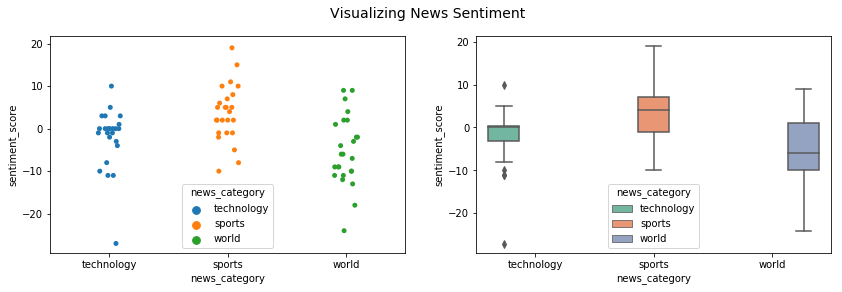

In [72]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


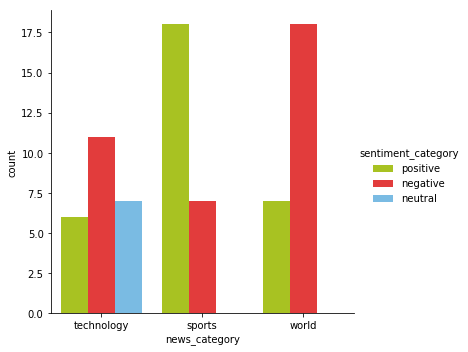

In [73]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [101]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 6)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -12)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

IndexError: ignored

In [102]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score ==1)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -12)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

IndexError: ignored

In [0]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [84]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                      ...                     
                        count      mean       std  ...    50%    75%    max
news_category                                      ...                     
sports                   25.0  0.130440  0.164542  ...  0.117  0.229  0.491
technology               24.0 -0.019333  0.186675  ... -0.034  0.025  0.400
world                    25.0  0.050360  0.193503  ...  0.037  0.136  0.360

[3 rows x 8 columns]

In [86]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,0.350,positive
1,technology,-0.250,negative
2,technology,-0.267,negative
3,technology,-0.092,negative
4,technology,0.200,positive


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


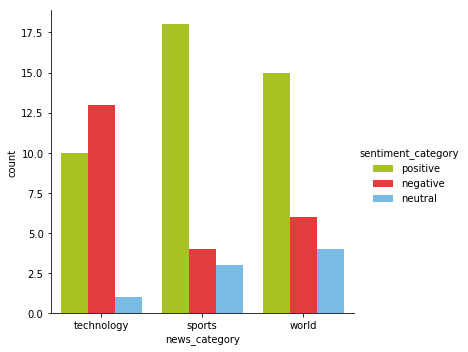

In [87]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [90]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.360)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.550	)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: At least 40 people have been killed and over 100 others have been injured in a blast at a wedding hall in Afghanistan, according to Afghanistan-based TOLO news. Members of minority Shi'ite Muslim community, who have been repeatedly attacked by Taliban and Islamic State, were reportedly holding a wedding reception at the hall. Government said it was a suicide bombing.

Most Positive World News Article: At least 63 people were killed and 182 were injured in a suicide blast on Saturday in Kabul. Following the blast, the groom said, "The attack changed my happiness to sorrow. My family and my bride are in shock...My bride keeps fainting," he said. "I lost my brother, friends, relatives. I'll never see happiness in my life again," he added.


In [0]:
#import model_evaluation_utils as meu
#meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
 #                                   predicted_labels=sentiment_category_tb, 
  #                                  classes=['negative', 'neutral', 'positive'])